In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Define the stiffness matrix
K = 10000* np.array([
                      [46.0, -22.0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [-22.0, 44.0, -22.0, 0, 0, 0, 0, 0, 0, 0],
                      [0, -22.0, 44.0, -22.0, 0, 0, 0, 0, 0, 0],
                      [0, 0, -22.0, 42.0, -20.0, 0, 0, 0, 0, 0],
                      [0, 0, 0, -20.0, 40.0, -20.0, 0, 0, 0, 0],
                      [0, 0, 0, 0, -20.0, 40.0, -20.0, 0, 0, 0],
                      [0, 0, 0, 0, 0, -20.0, 38.0, -18.0, 0, 0],
                      [0, 0, 0, 0, 0, 0, -18.0, 36.0, -18.0, 0],
                      [0, 0, 0, 0, 0, 0, 0, -18.0, 36.0, -18.0],
                      [0, 0, 0, 0, 0, 0, 0, 0, -18.0, 18.0]
                  ])

print(K.shape)

(10, 10)


In [3]:
K_inv = np.linalg.inv(K) # compute inverse of matrix

In [6]:
# generate training data of load vectors
p = np.random.uniform(low=0, high=1000, size=(100, 10))
print(p.shape)

(100, 10)


In [7]:
print(p.max())
print(p.min())

999.6350693546135
0.3967981817050159


In [8]:
# compute target data of displacements
u = K_inv @ p.T
print(u.shape)

(10, 100)


In [9]:
# adjust shape of displacement matrix
u = u.T
print(u.shape)

(100, 10)


# Scaling p Vectors

In [10]:
scaler = StandardScaler()
p = scaler.fit_transform(p)

# Machine Learning: Fully Connected Neural Network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(SimpleNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_1)
        self.fc4 = nn.Linear(hidden_size_1, output_size)
        self.selu = nn.SELU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.selu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.selu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.selu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [12]:
# Parameters
input_size = 10  # Number of input features
hidden_size_1 = 100  # Number of neurons in the hidden layer
hidden_size_2 = 200  # Number of neurons in the hidden layer
output_size = 10  # Output size (e.g., regression output)

# Create the neural network
model = SimpleNN(input_size, hidden_size_1,  hidden_size_2, output_size)

# Print the model architecture
print(model)

SimpleNN(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (selu): SELU()
  (dropout): Dropout(p=0.2, inplace=False)
)


# Training

In [13]:
# Convert numpy arrays to PyTorch tensors
u_tensor = torch.tensor(u, dtype=torch.float32)
p_tensor = torch.tensor(p, dtype=torch.float32)

In [14]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1000
error = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(p_tensor)
    loss = criterion(outputs, u_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0205
Epoch [200/1000], Loss: 0.0121
Epoch [300/1000], Loss: 0.0076
Epoch [400/1000], Loss: 0.0059
Epoch [500/1000], Loss: 0.0045
Epoch [600/1000], Loss: 0.0036
Epoch [700/1000], Loss: 0.0033
Epoch [800/1000], Loss: 0.0023
Epoch [900/1000], Loss: 0.0023
Epoch [1000/1000], Loss: 0.0018


Text(0, 0.5, 'Loss')

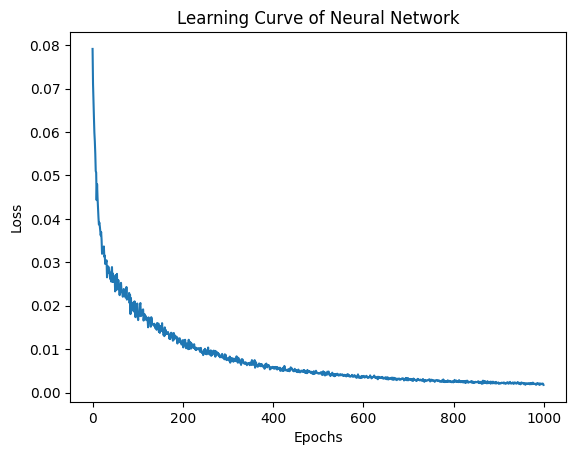

In [19]:
plt.plot(error)
plt.title('Learning Curve of Neural Network')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Prediction on Test Cases

In [15]:
# Test cases of load vectors 
p_test = np.array([[10, 100, 200, 300, 400, 500, 600, 700, 800, 900],
                   [500, 500, 500, 500, 500, 500, 500, 500, 500, 500,],
                   [200, 400, 600, 800, 900, 900, 800, 600, 400, 200],
                   [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100,],
                   [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
                   ])
p_test.shape

(5, 10)

In [16]:
# compute test cases of displacement vectors
u_test = K_inv @ p_test.T
u_test = u_test.T
print(u_test.shape)

(5, 10)


In [17]:
# scale test cases of load vectors
p_test = scaler.transform(p_test)
p_test_tensor = torch.tensor(p_test, dtype=torch.float32)

In [20]:
# Switch to evaluation mode
model.eval()

# Make predictions (no gradient computation needed)
with torch.no_grad():
    u_pred = model(p_test_tensor)

# Convert predictions to NumPy array if needed
u_pred = u_pred.numpy()

Text(0.5, 0.98, 'Comparing Test Cases of Floor Displacements')

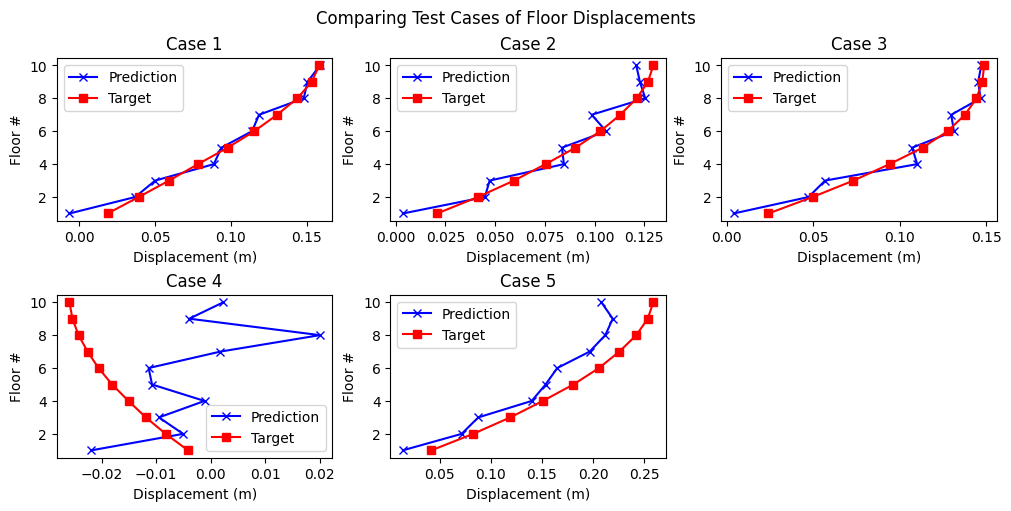

In [63]:
floors = np.arange(1, 11)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5), constrained_layout=True)
# fig.tight_layout()

axes[0,0].plot(u_pred[0,:], floors, 'bx-', label='Prediction')
axes[0,0].plot(u_test[0,:], floors, 'rs-', label='Target')
axes[0,0].set_title('Case 1')
axes[0,0].set_ylabel('Floor #')
axes[0,0].set_xlabel('Displacement (m)')
axes[0,0].legend()

axes[0,1].plot(u_pred[1,:], floors, 'bx-', label='Prediction')
axes[0,1].plot(u_test[1,:], floors, 'rs-', label='Target')
axes[0,1].set_title('Case 2')
axes[0,1].set_ylabel('Floor #')
axes[0,1].set_xlabel('Displacement (m)')
axes[0,1].legend()

axes[0,2].plot(u_pred[2,:], floors, 'bx-', label='Prediction')
axes[0,2].plot(u_test[2,:], floors, 'rs-', label='Target')
axes[0,2].set_title('Case 3')
axes[0,2].set_ylabel('Floor #')
axes[0,2].set_xlabel('Displacement (m)')
axes[0,2].legend()

axes[1,0].plot(u_pred[3,:], floors, 'bx-', label='Prediction')
axes[1,0].plot(u_test[3,:], floors, 'rs-', label='Target')
axes[1,0].set_title('Case 4')
axes[1,0].set_ylabel('Floor #')
axes[1,0].set_xlabel('Displacement (m)')
axes[1,0].legend()

axes[1,1].plot(u_pred[4,:], floors, 'bx-', label='Prediction')
axes[1,1].plot(u_test[4,:], floors, 'rs-', label='Target')
axes[1,1].set_title('Case 5')
axes[1,1].set_ylabel('Floor #')
axes[1,1].set_xlabel('Displacement (m)')
axes[1,1].legend()

fig.delaxes(axes[1][2])

fig.suptitle('Comparing Test Cases of Floor Displacements')

In [54]:
import pandas as pd
df_test = pd.DataFrame(u_test)
df_pred = pd.DataFrame(u_pred)

In [55]:
print('True Displacements')
display(df_test)

True Displacements


,0,1,2,3,4,5,6,7,8,9
0,0.018792,0.039246,0.059246,0.078337,0.097837,0.115337,0.130337,0.143670,0.153115,0.158115
1,0.020833,0.041288,0.059470,0.075379,0.090379,0.102879,0.112879,0.121212,0.126768,0.129545
2,0.024167,0.049621,0.073258,0.094167,0.113167,0.127667,0.137667,0.144333,0.147667,0.148778
3,-0.004167,-0.008258,-0.011894,-0.015076,-0.018076,-0.020576,-0.022576,-0.024242,-0.025354,-0.025909
4,0.041667,0.082576,0.118939,0.150758,0.180758,0.205758,0.225758,0.242424,0.253535,0.259091


In [56]:
print('Predicted Displacements')
display(df_pred)

Predicted Displacements


,0,1,2,3,4,5,6,7,8,9
0,-0.006316,0.036937,0.050130,0.088732,0.093672,0.113871,0.118472,0.147897,0.150355,0.158555
1,0.003613,0.044839,0.047232,0.084577,0.083576,0.105838,0.098507,0.125470,0.122787,0.120923
2,0.004050,0.047275,0.056887,0.110078,0.107188,0.131297,0.129741,0.146672,0.145319,0.147074
3,-0.021875,-0.005060,-0.009496,-0.001138,-0.010759,-0.011386,0.001764,0.020030,-0.003935,0.002328
4,0.013754,0.071301,0.087590,0.139914,0.153514,0.164938,0.196686,0.212000,0.219324,0.208121
